In [1]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
data_root = '~/Projects/TRACE-SEAS/FrontalZone/Data/'
east = xr.open_dataset(data_root+'frontal_zone_east_slice.nc').load()
south = xr.open_dataset(data_root+'frontal_zone_south_slice.nc').load()
top = xr.open_dataset(data_root+'frontal_zone_top_slice.nc').load()

In [3]:
###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

In [4]:
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.dpi'] = 120  

### Buoyancy field

/glade/scratch/zhihuaz/ipykernel_114292/1246589766.py:86: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for coll in Ct.collections:
/glade/scratch/zhihuaz/ipykernel_114292/1246589766.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for coll in Cs.collections:
/glade/scratch/zhihuaz/ipykernel_114292/1246589766.py:90: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for coll in Ce.collections:


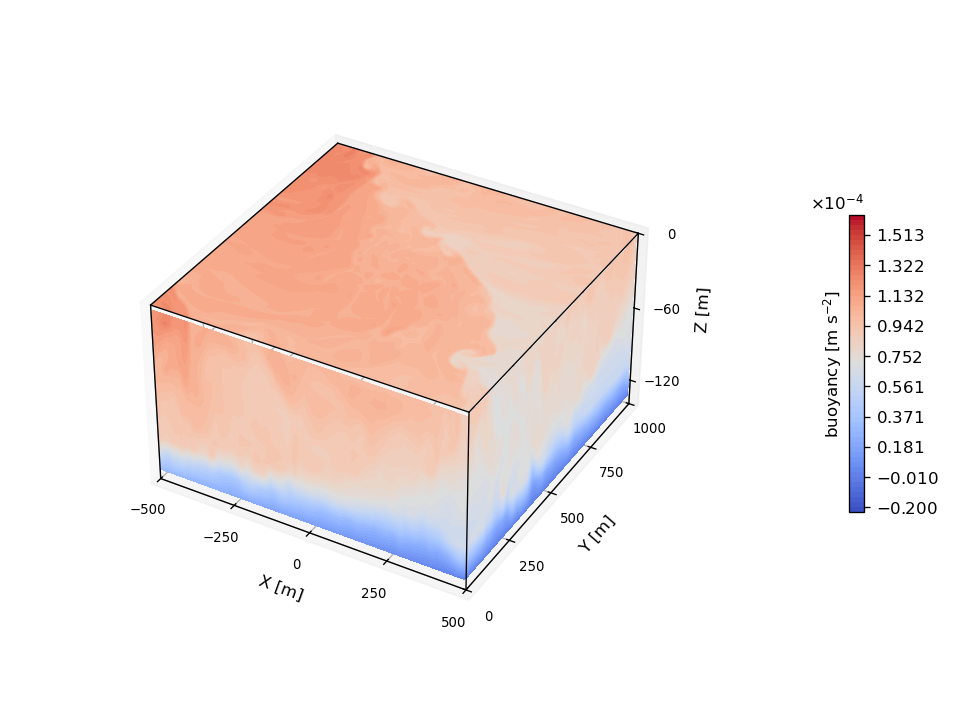

In [5]:
# Define dimensions
Nx, Ny, Nz = 128, 128, 16
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zC)

itime = 0
Bbak = -3e-8*X
bmin = min([(top.b.isel(zC=0).transpose('time','xC','yC') + Bbak[:,:,-1]).min(), 
            (east.b.isel(xC=0).transpose('time','yC','zC') + Bbak[:,-1,:]).min(), 
            (south.b.isel(yC=0).transpose('time','xC','zC') + Bbak[0,:,:]).min()])
bmax = max([(top.b.isel(zC=0).transpose('time','xC','yC') + Bbak[:,:,-1]).max(), 
            (east.b.isel(xC=0).transpose('time','yC','zC') + Bbak[:,-1,:]).max(), 
            (south.b.isel(yC=0).transpose('time','xC','zC') + Bbak[0,:,:]).max()])
kw = {
    'vmin': bmin,
    'vmax': bmax,
    'levels': np.linspace(bmin, bmax, 60),
    'cmap': 'coolwarm'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
Ct = ax.contourf(
    X[:, :, -1], Y[:, :, -1], top.b.isel(time=itime,zC=0).transpose('yC','xC') + Bbak[:,:,-1],
    zdir='z', offset=0, **kw
)
Cs = ax.contourf(
    X[0, :, :], south.b.isel(time=itime,yC=0).transpose('xC','zC') + Bbak[0,:,:], Z[0, :, :],
    zdir='y', offset=0, **kw
)
Ce = ax.contourf(
    east.b.isel(time=itime,xC=0).transpose('yC','zC') + Bbak[:,-1,:], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --

# Plot edges
xmin, xmax = -500, 500
ymin, ymax = 0, 1000
zmin, zmax = -140, 0
edges_kw = dict(color='k', linewidth=0.8, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)
ax.tick_params(axis='both', labelsize=8)

# Set zoom and angle view
ax.view_init(35, -60, 0)
ax.set_box_aspect((1,1,0.6), zoom=1)

# Colorbar
cbar = fig.colorbar(Ce, ax=ax, fraction=0.02, pad=0.25)
cbar.set_label(r'buoyancy [m s$^{-2}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

# Set limits of the plot from coord limits
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax]);

# plt.savefig('../Figures/b3d_initial.png', dpi=150)
# plt.savefig('../Figures/b3d_mid.png', dpi=150)


def update(frame):
    global Ct, Cs, Ce, top, south, east, X, Y, Z, kw
    # for each frame, get new data and clear old data stored on each artist
    top_field = top.b.isel(time=frame,zC=0).transpose('yC','xC') + Bbak[:,:,-1]
    south_field = south.b.isel(time=frame,yC=0).transpose('xC','zC') + Bbak[0,:,:]
    east_field = east.b.isel(time=frame,xC=0).transpose('yC','zC') + Bbak[:,-1,:]
    for coll in Ct.collections:
        coll.remove()
    for coll in Cs.collections:
        coll.remove()
    for coll in Ce.collections:
        coll.remove()
    # update the plot
    Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
    Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
    Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
    return (Ct, Cs, Ce)

ani = animation.FuncAnimation(fig=fig, func=update, frames=14, interval=30, repeat_delay=100);#top.dims['time']
ani.save('../Figures/b3d.gif', writer='pillow', fps=2)

### Vertical velocity field

In [ ]:
Nx, Ny, Nz = 128, 128, 17
X, Y, Z = np.meshgrid(south.xC, east.yC, east.zF)

wmin = min([(top.w.isel(zF=0).transpose('time','xC','yC')).min(), 
            (east.w.isel(xC=0).transpose('time','yC','zF')).min(), 
            (south.w.isel(yC=0).transpose('time','xC','zF')).min()])
wmax = max([(top.w.isel(zF=0).transpose('time','xC','yC')).max(), 
            (east.w.isel(xC=0).transpose('time','yC','zF')).max(), 
            (south.w.isel(yC=0).transpose('time','xC','zF')).max()])
wamp = np.floor(max([abs(wmin), abs(wmax)])*1e2)/1e2

kw = {
    'vmin': -wamp,
    'vmax': wamp,
    'levels': np.linspace(-wamp, wamp, 25),
    'cmap': 'RdBu_r',
    'extend': 'both'
}

# Create a figure with 3D ax
plt.close()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
Ct = ax.contourf(
    X[:, :, -1], Y[:, :, -1], top.w.isel(time=itime,zF=0).transpose('yC','xC'),
    zdir='z', offset=0, **kw
)
Cs = ax.contourf(
    X[0, :, :], south.w.isel(time=itime,yC=0).transpose('xC','zF'), Z[0, :, :],
    zdir='y', offset=0, **kw
)
Ce = ax.contourf(
    east.w.isel(time=itime,xC=0).transpose('yC','zF'), Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --

# Plot edges
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax], **edges_kw)
ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [m]',
    ylabel='Y [m]',
    zlabel='Z [m]',
    zticks=[0, -60, -120],
    xticks=[-500, -250, 0, 250, 500],
    yticks=[0, 250, 500, 750, 1000]
)
ax.tick_params(axis='both', labelsize=8)

# Set zoom and angle view
ax.view_init(35, -60, 0)
ax.set_box_aspect((1,1,0.6), zoom=1)

# Colorbar
cbar = fig.colorbar(Ce, ax=ax, fraction=0.02, pad=0.22)
cbar.set_label(r'w [m s$^{-1}$]', labelpad=-70)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
cbar.ax.set_yticks(np.linspace(-wamp, wamp, 7))

# Set limits of the plot from coord limits
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax]);

# plt.savefig('../Figures/b3d_initial.png', dpi=150)
# plt.savefig('../Figures/b3d_mid.png', dpi=150)


def update(frame):
    global Ct, Cs, Ce, top, south, east, X, Y, Z, kw
    # for each frame, get new data and clear old data stored on each artist
    top_field = top.w.isel(time=frame,zF=0).transpose('yC','xC')
    south_field = south.w.isel(time=frame,yC=0).transpose('xC','zF')
    east_field = east.w.isel(time=frame,xC=0).transpose('yC','zF')
    for coll in Ct.collections:
        coll.remove()
    for coll in Cs.collections:
        coll.remove()
    for coll in Ce.collections:
        coll.remove()
    # update the plot
    Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], top_field, zdir='z', offset=0, **kw)
    Cs = ax.contourf(X[0, :, :], south_field, Z[0, :, :], zdir='y', offset=0, **kw)
    Ce = ax.contourf(east_field, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=X.max(), **kw)
    return (Ct, Cs, Ce)

ani = animation.FuncAnimation(fig=fig, func=update, frames=14, interval=300, repeat_delay=100);#top.dims['time']
ani.save('../Figures/w3d.gif', writer='pillow', fps=2)